In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import joblib

# 1. 원본 데이터 파일
INPUT_CSV = 'second_final_data_proceed.csv'
TARGET_COLUMN = 'tsunami' # 타겟(y) 컬럼 이름

# 2. ★★★ 예측 스크립트와 호환되는 6개 특성 ★★★
FEATURE_COLUMNS = [
    'magnitude',
    'depth',
    'is_ocean',
    'is_steep_slope',
    'horizontal_count_1y_full', # (h_count)
    'vertical_count_1y_full'    # (v_count)
]

# 3. 저장할 파일 이름
SCALER_OUTPUT = 'tsunami_scaler.joblib' # (스케일러 모델 파일)
SCALED_DATA_OUTPUT = 'second_final_data_proceed_scaler.csv' # (정형화된 데이터 파일)

def create_scaler_and_scaled_data():
    """
    (수정됨) 6-feature 스케일러를 생성하고, 스케일러(.joblib)와
    정형화된 데이터(.csv)를 모두 저장합니다.
    """
    try:
        # 원본 데이터 로드
        df = pd.read_csv(INPUT_CSV)
        print(f"'{INPUT_CSV}' 로드 완료.")

        # 6개 특성(X)과 타겟(y) 분리
        X_features = df[FEATURE_COLUMNS]
        y_target = df[TARGET_COLUMN]

        print(f"예측 호환용 6개 특성 선택 완료: {FEATURE_COLUMNS}")

        # StandardScaler 생성 및 학습(fit)
        scaler = StandardScaler()
        scaler.fit(X_features)

        print("StandardScaler 학습(fit) 완료.")

        # --- 작업 1: 스케일러(모델) 파일 저장 ---
        joblib.dump(scaler, SCALER_OUTPUT)
        print(f"\n[작업 1] 성공! 스케일러가 '{SCALER_OUTPUT}' 파일로 저장되었습니다.")


        # --- 작업 2: 정형화된 데이터 파일 저장 (사용자 요청 추가) ---
        print(f"\n[작업 2] 데이터를 변환하여 '{SCALED_DATA_OUTPUT}' 파일로 저장합니다...")

        # 1. 스케일러로 6개 특성 데이터를 변환(transform)
        X_scaled = scaler.transform(X_features)

        # 2. 변환된 NumPy 배열을 다시 DataFrame으로 만듦 (컬럼명 복원)
        df_scaled_features = pd.DataFrame(X_scaled, columns=FEATURE_COLUMNS)

        # 3. 타겟(tsunami) 열을 다시 결합
        df_final_scaled_data = df_scaled_features.copy()
        df_final_scaled_data[TARGET_COLUMN] = y_target.values

        # 4. 새 CSV 파일로 저장
        df_final_scaled_data.to_csv(SCALED_DATA_OUTPUT, index=False)

        print(f"성공! 정형화된 데이터(6-features + target)가 '{SCALED_DATA_OUTPUT}' 파일로 저장되었습니다.")

        print("\n이제 'train_v18_model.py' 스크립트를 실행하여 모델을 훈련할 수 있습니다.")

    except FileNotFoundError:
        print(f"오류: '{INPUT_CSV}' 파일을 찾을 수 없습니다.")
    except KeyError as e:
        print(f"오류: '{INPUT_CSV}' 파일에 필요한 특성 열이 없습니다: {e}")
        print(f"필요한 열: {FEATURE_COLUMNS} 또는 '{TARGET_COLUMN}'")
    except Exception as e:
        print(f"작업 중 오류 발생: {e}")

if __name__ == "__main__":
    create_scaler_and_scaled_data()

오류: 'second_final_data_proceed.csv' 파일을 찾을 수 없습니다.


In [19]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score
import joblib
import warnings

# 경고 메시지 무시
warnings.filterwarnings('ignore')

def train_model_from_preprocessed(input_file, model_output_file):
    """
    이미 전처리된 데이터를 로드하여 XGBoost 모델을 훈련시키고,
    성능을 평가한 뒤 모델을 저장합니다.
    """
    try:
        # 1. 전처리된 데이터 로드
        df = pd.read_csv(input_file)
        print(f"전처리된 파일 '{input_file}' 로드 완료. (총 {len(df)}개 행)")

        # 2. 피처(X)와 타겟(y) 분리
        target_column = 'tsunami'
        if target_column not in df.columns:
            print(f"오류: 타겟 컬럼 '{target_column}'을 찾을 수 없습니다.")
            return

        X = df.drop(target_column, axis=1)
        y = df[target_column]
        print("피처(X)와 타겟(y) 분리 완료.")

        # 3. 학습 데이터와 테스트 데이터 분리 (80% 학습, 20% 테스트)
        # stratify=y : 원본 데이터의 타겟(tsunami) 비율을 유지하며 분리
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,  # 스케일링된 X를 바로 사용
            test_size=0.2,
            random_state=42,
            stratify=y
        )
        print(f"데이터 분리 완료: 학습용 {len(X_train)}개, 테스트용 {len(X_test)}개")

        # 4. XGBoost 모델 초기화 및 학습
        # scale_pos_weight: 타겟(y)의 0과 1 비율 불균형을 보정합니다.
        # (0의 개수 / 1의 개수)
        ratio = (y == 0).sum() / (y == 1).sum()

        model = xgb.XGBClassifier(
            objective='binary:logistic',  # 이진 분류
            scale_pos_weight=ratio,       # 클래스 불균형 보정
            eval_metric='logloss',
            random_state=42,
            use_label_encoder=False # 최신 XGBoost 호환성
        )

        print("\nXGBoost 모델 학습 시작...")
        model.fit(X_train, y_train)
        print("모델 학습 완료.")

        # 5. 모델 성능 평가 (테스트 데이터)
        y_pred = model.predict(X_test)

        # 정확도 (Accuracy)
        accuracy = accuracy_score(y_test, y_pred)

        # 정밀도 (Precision): 모델이 '쓰나미 발생(1)'이라고 예측한 것 중, '실제 쓰나미(1)'인 비율
        precision = precision_score(y_test, y_pred)

        print("\n--- 모델 성능 평가 (Test Set) ---")
        print(f"정확도 (Accuracy):   {accuracy * 100:.2f} %")
        print(f"정밀도 (Precision): {precision * 100:.2f} %")
        print("---------------------------------")

        # 6. 훈련된 모델 파일로 저장
        joblib.dump(model, model_output_file)
        print(f"\n훈련된 XGBoost 모델 저장 완료: '{model_output_file}'")

    except FileNotFoundError:
        print(f"오류: '{input_file}' 파일을 찾을 수 없습니다.")
        print("이 스크립트는 'scaled_final_model_data.csv' 파일이 필요합니다.")
    except Exception as e:
        print(f"작업 중 오류 발생: {e}")

# --- 스크립트 실행 ---
if __name__ == "__main__":
    # [중요] 입력 파일로 'scaled_final_model_data.csv'을 사용합니다.
    INPUT_CSV = 'scaled_model_data_6features.csv'
    MODEL_OUTPUT = 'xgboost_tsunami_model.joblib'

    train_model_from_preprocessed(INPUT_CSV, MODEL_OUTPUT)

전처리된 파일 'scaled_model_data_6features.csv' 로드 완료. (총 802개 행)
피처(X)와 타겟(y) 분리 완료.
데이터 분리 완료: 학습용 641개, 테스트용 161개

XGBoost 모델 학습 시작...
모델 학습 완료.

--- 모델 성능 평가 (Test Set) ---
정확도 (Accuracy):   60.25 %
정밀도 (Precision): 50.82 %
---------------------------------

훈련된 XGBoost 모델 저장 완료: 'xgboost_tsunami_model.joblib'


In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import joblib

# 1. 원본 데이터 파일
INPUT_CSV = 'final_model_dataset.csv'

# 2. ★★★ 예측 스크립트와 호환되는 6개 특성 ★★★
# (예측 스크립트의 X_new = np.array([...]) 순서와 정확히 일치해야 함)
FEATURE_COLUMNS = [
    'magnitude',
    'depth',
    'is_ocean',
    'is_steep_slope',
    'horizontal_count_1y_full', # (h_count)
    'vertical_count_1y_full'    # (v_count)
]

# 3. 예측 스크립트가 요구하는 스케일러 파일 이름
SCALER_OUTPUT = 'tsunami_scaler.joblib'

def create_compatible_scaler():
    """
    예측 스크립트(V18)와 호환되는 6-feature 스케일러를 생성하고 저장합니다.
    """
    try:
        # 원본 데이터 로드
        df = pd.read_csv(INPUT_CSV)
        print(f"'{INPUT_CSV}' 로드 완료.")

        # 6개 특성만 선택
        X_features = df[FEATURE_COLUMNS]
        print(f"예측 호환용 6개 특성 선택 완료: {FEATURE_COLUMNS}")

        # StandardScaler 생성 및 학습(fit)
        scaler = StandardScaler()
        scaler.fit(X_features)

        print("StandardScaler 학습(fit) 완료.")

        # 학습된 스케일러 객체를 파일로 저장
        joblib.dump(scaler, SCALER_OUTPUT)

        print(f"\n성공! '{SCALER_OUTPUT}' 파일이 저장되었습니다.")
        print("이제 'train_v18_model.py' 스크립트를 실행하세요.")

    except FileNotFoundError:
        print(f"오류: '{INPUT_CSV}' 파일을 찾을 수 없습니다.")
    except KeyError:
        print(f"오류: '{INPUT_CSV}' 파일에 필요한 특성 열이 없습니다.")
        print(f"필요한 열: {FEATURE_COLUMNS}")
    except Exception as e:
        print(f"작업 중 오류 발생: {e}")

if __name__ == "__main__":
    create_compatible_scaler()

'final_model_dataset.csv' 로드 완료.
예측 호환용 6개 특성 선택 완료: ['magnitude', 'depth', 'is_ocean', 'is_steep_slope', 'horizontal_count_1y_full', 'vertical_count_1y_full']
StandardScaler 학습(fit) 완료.

성공! 'tsunami_scaler.joblib' 파일이 저장되었습니다.
이제 'train_v18_model.py' 스크립트를 실행하세요.


In [13]:
import pandas as pd

# --- 설정 ---
INPUT_FILE = 'final_model_data.csv'
OUTPUT_FILE = 'final_model_data_6features.csv'

# 제거할 컬럼 목록
COLUMNS_TO_DROP = [
    'latitude',
    'longitude',
    'Year',
    'Month'
]

# (참고) 최종적으로 남게 될 컬럼 목록
# Features: 'magnitude', 'depth', 'is_ocean', 'is_steep_slope',
#           'horizontal_count_1y_full', 'vertical_count_1y_full'
# Target: 'tsunami'

def extract_6_features(input_file, output_file, columns_to_drop):
    """
    원본 데이터 파일에서 지정된 컬럼들을 제거하고 새 파일로 저장합니다.
    """
    try:
        # 1. 원본 데이터 로드
        df = pd.read_csv(input_file)
        print(f"'{input_file}' 로드 완료. (원본 컬럼: {list(df.columns)})")

        # 2. 지정된 컬럼 제거
        # df.drop()은 컬럼이 없는 경우 오류를 발생시킬 수 있으므로,
        # 현재 데이터프레임에 '있는' 컬럼만 제거하도록 처리합니다.

        existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]

        if not existing_columns_to_drop:
            print(f"제거할 컬럼이 '{input_file}'에 존재하지 않습니다.")
            return

        df_reduced = df.drop(columns=existing_columns_to_drop)

        print(f"컬럼 제거 완료: {existing_columns_to_drop}")

        # 3. 새 파일로 저장
        df_reduced.to_csv(output_file, index=False)

        print(f"\n성공! 6-feature 데이터셋이 '{output_file}'로 저장되었습니다.")
        print(f"저장된 컬럼: {list(df_reduced.columns)}")
        print("\n이제 이 파일을 사용하여 '스케일러 생성' 및 '모델 훈련'을 진행할 수 있습니다.")

    except FileNotFoundError:
        print(f"오류: '{input_file}' 파일을 찾을 수 없습니다.")
    except Exception as e:
        print(f"작업 중 오류 발생: {e}")

# --- 스크립트 실행 ---
if __name__ == "__main__":
    extract_6_features(INPUT_FILE, OUTPUT_FILE, COLUMNS_TO_DROP)

'final_model_data.csv' 로드 완료. (원본 컬럼: ['magnitude', 'depth', 'latitude', 'longitude', 'Year', 'Month', 'tsunami', 'is_ocean', 'is_steep_slope', 'horizontal_count_1y_full', 'vertical_count_1y_full'])
컬럼 제거 완료: ['latitude', 'longitude', 'Year', 'Month']

성공! 6-feature 데이터셋이 'final_model_data_6features.csv'로 저장되었습니다.
저장된 컬럼: ['magnitude', 'depth', 'tsunami', 'is_ocean', 'is_steep_slope', 'horizontal_count_1y_full', 'vertical_count_1y_full']

이제 이 파일을 사용하여 '스케일러 생성' 및 '모델 훈련'을 진행할 수 있습니다.



데이터 분리 완료: 총 802건 -> 학습 601건, 테스트 201건
XGBoost 모델 학습 시작...
모델 학습 완료.

--- 1. 분류 리포트 (정밀도, 재현율, F1-Score) ---
                precision    recall  f1-score   support

Tsunami 없음 (0)       0.65      0.68      0.66       120
Tsunami 발생 (1)       0.49      0.47      0.48        81

      accuracy                           0.59       201
     macro avg       0.57      0.57      0.57       201
  weighted avg       0.59      0.59      0.59       201


--- 2. 오차 행렬 (Confusion Matrix) ---
[[81 39]
 [43 38]]


C:\Users\admin\AppData\Roaming\Python\Python310\site-packages\xgboost\training.py:199: UserWarning: [12:42:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\admin\AppData\Roaming\Python\Python310\site-packages\seaborn\utils.py:61: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
C:\Users\admin\AppData\Roaming\Python\Python310\site-packages\seaborn\utils.py:61: UserWarning: Glyph 11093 (\N{HEAVY LARGE CIRCLE}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
C:\Users\admin\AppData\Roaming\Python\Python310\site-packages\seaborn\utils.py:61: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
C:\Users\admin\AppData\Local\Temp\ipykernel_9856\3706612432.py:101: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Malgun Gothic.
  plt.savefig("c

결과 저장: confusion_matrix.png

--- 3. ROC Curve & AUC 점수 ---
AUC (Area Under Curve) 점수: 0.6464
결과 저장: roc_curve.png

--- 4. 특성 중요도 (Feature Importance) ---
                    feature  importance
4  horizontal_count_1y_full    0.189545
3            is_steep_slope    0.185757
5    vertical_count_1y_full    0.171619
2                  is_ocean    0.162843
0                 magnitude    0.149044
1                     depth    0.141193


C:\Users\admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\_plotting.py:379: FutureWarning: `estimator_name` is deprecated in 1.7 and will be removed in 1.9. Use `name` instead.
  warnings.warn(


결과 저장: feature_importance.png

모든 분석 및 시각화가 완료되었습니다.


C:\Users\admin\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\admin\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 11093 (\N{HEAVY LARGE CIRCLE}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\admin\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


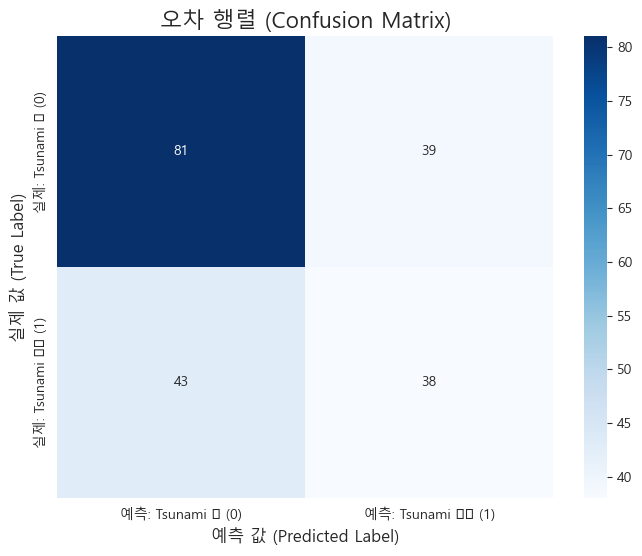

<Figure size 800x600 with 0 Axes>

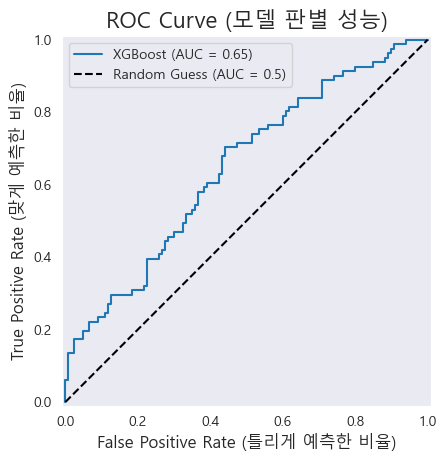

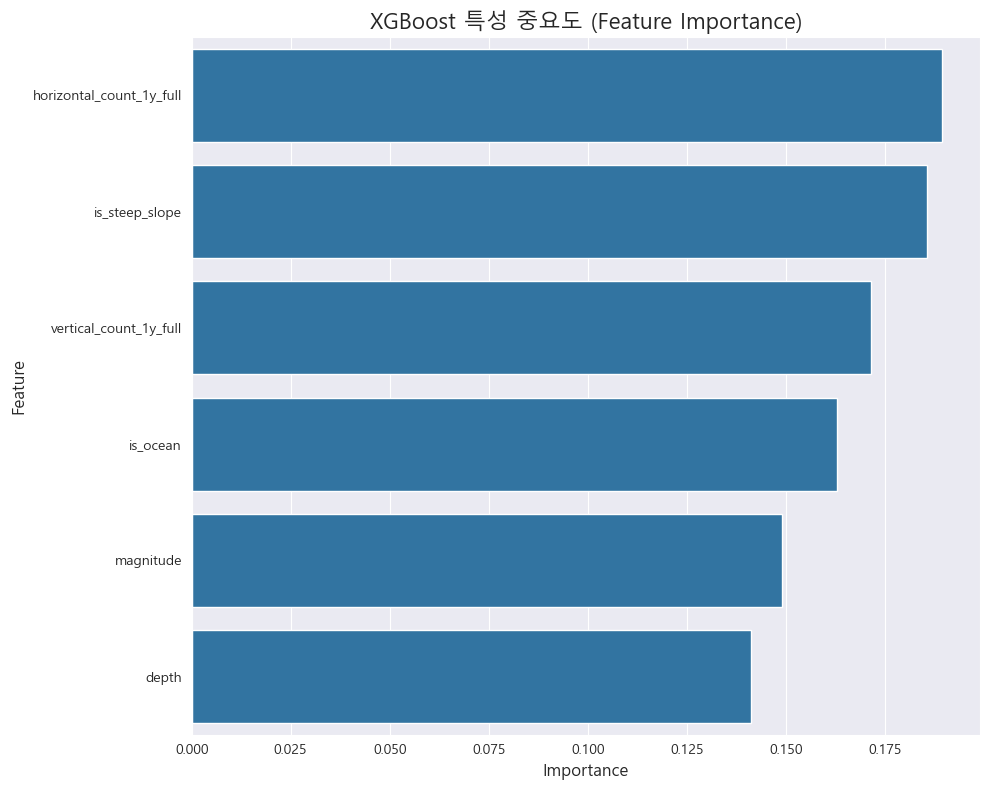

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    RocCurveDisplay
)
from xgboost import XGBClassifier
import os

def setup_korean_font():
    """운영체제에 맞는 한글 폰트를 설정합니다."""
    try:
        if os.name == 'nt':  # Windows
            plt.rc('font', family='Malgun Gothic')
        elif os.name == 'posix':  # macOS
            plt.rc('font', family='AppleGothic')
    except:
        print("한글 폰트(맑은 고딕 또는 AppleGothic)를 찾을 수 없습니다. 그래프의 한글이 깨질 수 있습니다.")

    plt.rc('axes', unicode_minus=False) # 마이너스 기호 깨짐 방지

def run_xgboost_evaluation(csv_file_path):
    """
    CSV 파일로 XGBoost 모델을 학습하고
    모든 주요 평가지표와 특성 중요도를 출력 및 저장합니다.
    """
    try:
        # 1. 데이터 로드 및 전처리
        df = pd.read_csv(csv_file_path)

        # bool(True/False) 타입을 1/0 정수형으로 변환
        for col in df.columns:
            if df[col].dtype == 'bool':
                print(f"전처리: '{col}' 불리언(bool) 타입을 0/1 정수형으로 변환합니다.")
                df[col] = df[col].astype(int)

        # 2. X (특성), y (타겟) 분리
        if 'tsunami' not in df.columns:
            print("오류: 'tsunami' 열을 찾을 수 없습니다.")
            return

        y = df['tsunami']
        X = df.drop('tsunami', axis=1)

        # 3. 학습/테스트 데이터 분리 (stratify=y: 0과 1의 비율을 유지하며 분리)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=0.25,  # 25%를 테스트 세트로 사용
            random_state=42, # 결과를 동일하게 재현하기 위함
            stratify=y       # 쓰나미 0/1 비율을 유지 (중요!)
        )
        print(f"\n데이터 분리 완료: 총 {len(df)}건 -> 학습 {len(X_train)}건, 테스트 {len(X_test)}건")

        # 4. XGBoost 모델 학습
        print("XGBoost 모델 학습 시작...")
        model = XGBClassifier(
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss'
        )
        model.fit(X_train, y_train)
        print("모델 학습 완료.")

        # 5. 예측 수행
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1] # ROC용 확률 예측

        # --- 6. 모델 성능 평가 (모든 지표) ---

        # (필수) 한글 폰트 설정
        setup_korean_font()

        # 지표 1: 분류 리포트 (정밀도, 재현율, F1-Score)
        print("\n--- 1. 분류 리포트 (정밀도, 재현율, F1-Score) ---")
        report = classification_report(
            y_test,
            y_pred,
            target_names=['Tsunami 없음 (0)', 'Tsunami 발생 (1)']
        )
        print(report)
        # --------------------------------------------------

        # 지표 2: 오차 행렬 (Confusion Matrix)
        print("\n--- 2. 오차 행렬 (Confusion Matrix) ---")
        cm = confusion_matrix(y_test, y_pred)
        print(cm)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['예측: Tsunami ❌ (0)', '예측: Tsunami ⭕️ (1)'],
                    yticklabels=['실제: Tsunami ❌ (0)', '실제: Tsunami ⭕️ (1)'])
        plt.title('오차 행렬 (Confusion Matrix)', fontsize=16)
        plt.ylabel('실제 값 (True Label)', fontsize=12)
        plt.xlabel('예측 값 (Predicted Label)', fontsize=12)
        plt.savefig("confusion_matrix.png")
        print("결과 저장: confusion_matrix.png")
        # plt.show() # PyCharm에서 실행 시 주석 해제
        # --------------------------------------------------

        # 지표 3: ROC Curve 및 AUC Score
        print("\n--- 3. ROC Curve & AUC 점수 ---")
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        auc_score = auc(fpr, tpr)
        print(f"AUC (Area Under Curve) 점수: {auc_score:.4f}")

        plt.figure(figsize=(8, 6))
        RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_score, estimator_name='XGBoost').plot()
        plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.5)')
        plt.title('ROC Curve (모델 판별 성능)', fontsize=16)
        plt.xlabel('False Positive Rate (틀리게 예측한 비율)', fontsize=12)
        plt.ylabel('True Positive Rate (맞게 예측한 비율)', fontsize=12)
        plt.legend()
        plt.grid()
        plt.savefig("roc_curve.png")
        print("결과 저장: roc_curve.png")
        # plt.show() # PyCharm에서 실행 시 주석 해제
        # --------------------------------------------------

        # --- 7. 모델 해석 (특성 중요도) ---
        print("\n--- 4. 특성 중요도 (Feature Importance) ---")
        importances = model.feature_importances_
        feature_names = X.columns

        # 중요도를 DataFrame으로 변환하여 정렬
        feature_imp_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values(by='importance', ascending=False)

        print(feature_imp_df)

        plt.figure(figsize=(10, 8))
        sns.barplot(x='importance', y='feature', data=feature_imp_df)
        plt.title('XGBoost 특성 중요도 (Feature Importance)', fontsize=16)
        plt.xlabel('Importance', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.tight_layout()
        plt.savefig("feature_importance.png")
        print("결과 저장: feature_importance.png")
        # plt.show() # PyCharm에서 실행 시 주석 해제
        # --------------------------------------------------

        print("\n모든 분석 및 시각화가 완료되었습니다.")
        # 모든 플롯을 한 번에 표시
        plt.show()

    except FileNotFoundError:
        print(f"오류: 파일을 찾을 수 없습니다. '{csv_file_path}' 경로를 확인하세요.")
    except Exception as e:
        print(f"알 수 없는 오류가 발생했습니다: {e}")

# --- 스크립트 실행 ---
if __name__ == "__main__":
    # 이 스크립트와 같은 폴더에 CSV 파일이 있어야 합니다.
    file_to_process = 'final_802_data_for_training.csv'
    run_xgboost_evaluation(file_to_process)